# Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
import yfinance as yf

ticker_symbol = "TD"
period = "5y"

# Download historical data for TD Bank (TD) for the last 5 years
# df = yf.download(ticker_symbol, period=period)
df = pd.read_csv("TD.csv")

df.head(3)

,Date,Close,High,Low,Open,Volume
0,2020-04-02,32.043697,32.904788,31.477611,31.812481,2871600
1,2020-04-03,31.445711,32.282884,31.110844,32.003825,2213500
2,2020-04-06,33.271542,33.383164,32.258964,32.569912,4587500


# EDA

In [3]:
# df = df.reset_index()
# df.columns.get_level_values(1)
# df.columns = df.columns.droplevel(1)
# df.head(3)

In [4]:
df.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [5]:
df.dtypes

Date       object
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

# Time Series Analysis

In [6]:
def plot_time_series_chart(df, x_col, y_col, y_label='Y Axis', title='Line Plot'):
    """
    Plot a single line over time.

    Parameters:
    - df (pd.DataFrame): The input DataFrame
    - x_col (str): Column name for x-axis
    - y_col (str): Column name for y-axis
    - y_label (str): Label for y-axis
    - title (str): Title of the plot
    """

    plt.figure(figsize=(12, 6))
    plt.plot(df[x_col], df[y_col], color='green', label=y_col)

    plt.xlabel(x_col.capitalize())
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

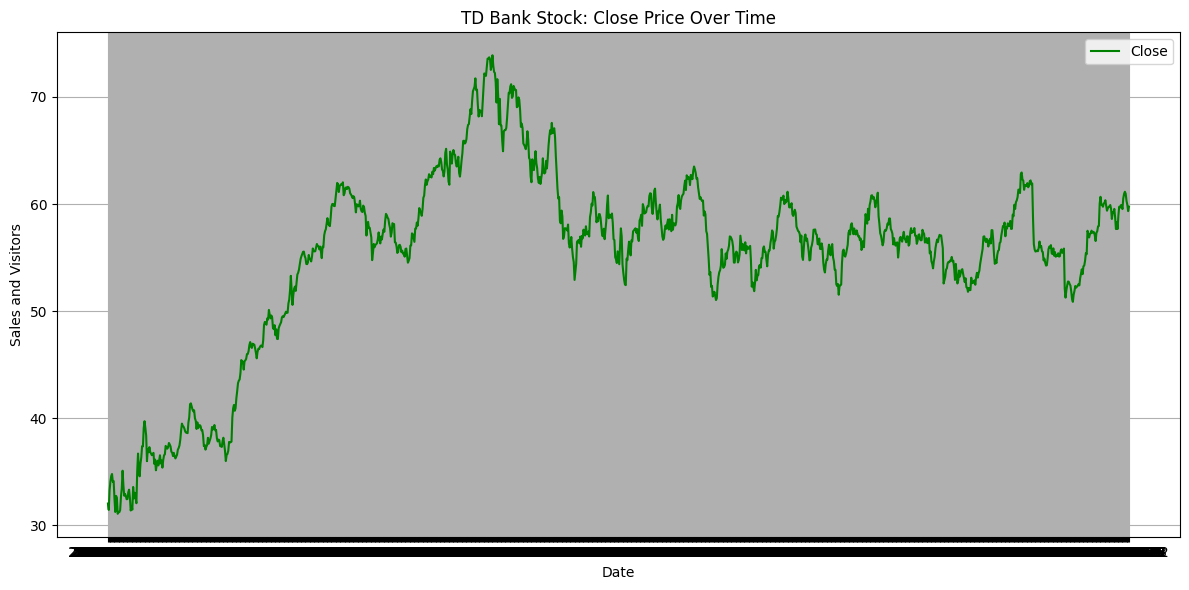

In [7]:
plot_time_series_chart(
    df=df,
    x_col='Date',
    y_col='Close',
    y_label='Sales and Visitors',
    title='TD Bank Stock: Close Price Over Time'
)

# Detect Outliers

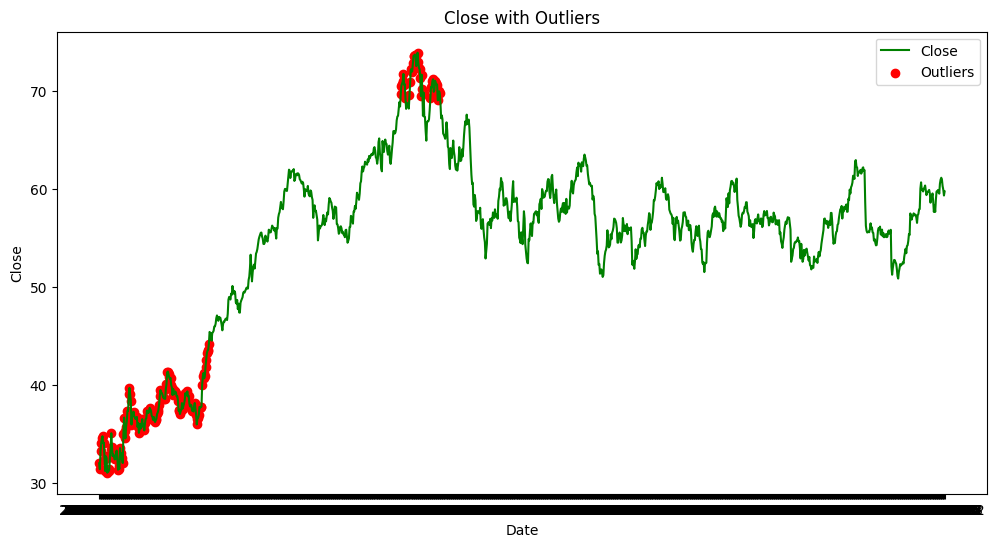


Outliers in 'Close':


,Date,Close,High,Low,Open,Volume
0,2020-04-02,32.043697,32.904788,31.477611,31.812481,2871600
1,2020-04-03,31.445711,32.282884,31.110844,32.003825,2213500
2,2020-04-06,33.271542,33.383164,32.258964,32.569912,4587500
3,2020-04-07,34.092766,35.304670,33.861550,34.722638,3449300
4,2020-04-08,34.597752,34.735110,33.595857,34.177601,2532300


In [8]:
def detect_outliers_iqr(df, column, date_column='Date'):
    """
    Detect and visualize outliers in a specified column using the IQR method.

    Parameters:
    - df (pd.DataFrame): The input DataFrame
    - column (str): The name of the column to check for outliers
    - date_column (str): The name of the date/time column (for plotting)

    Returns:
    - outliers (pd.DataFrame): Rows where outliers were detected
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    plt.figure(figsize=(12, 6))
    plt.plot(df[date_column], df[column], label=column.capitalize(), color='green')
    plt.scatter(outliers[date_column], outliers[column], color='red', label='Outliers')
    plt.xlabel('Date')
    plt.ylabel(column.capitalize())
    plt.title(f'{column.capitalize()} with Outliers')
    plt.title(f'{column.capitalize()} with Outliers')
    plt.legend()
    plt.grid(False)
    plt.show()

    # Print and visualize
    print(f"\nOutliers in '{column}':")

    return outliers.head()

detect_outliers_iqr(df, 'Close')

# Classical Time Series Decomposition

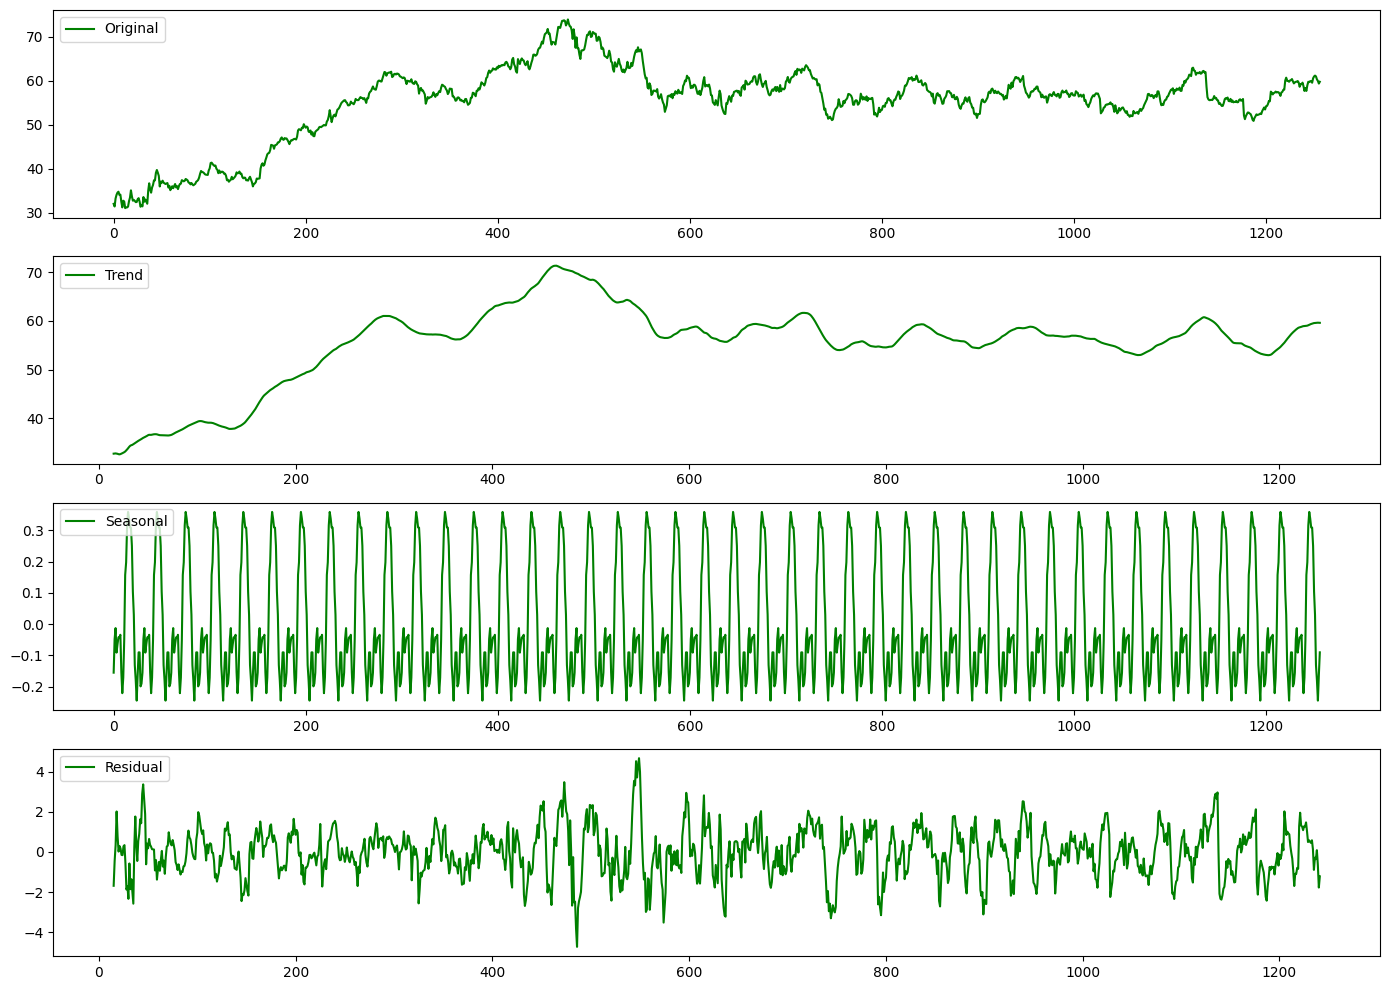

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_additive = seasonal_decompose(df['Close'], model='additive', period=30)
trend_additive         = decomposition_additive.trend
seasonal_additive      = decomposition_additive.seasonal
residual_additive      = decomposition_additive.resid

# Plotting the additive decomposition
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(df['Close'], label='Original', color = 'green')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend_additive, label='Trend', color = 'green')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal_additive, label='Seasonal', color = 'green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual_additive, label='Residual', color = 'green')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


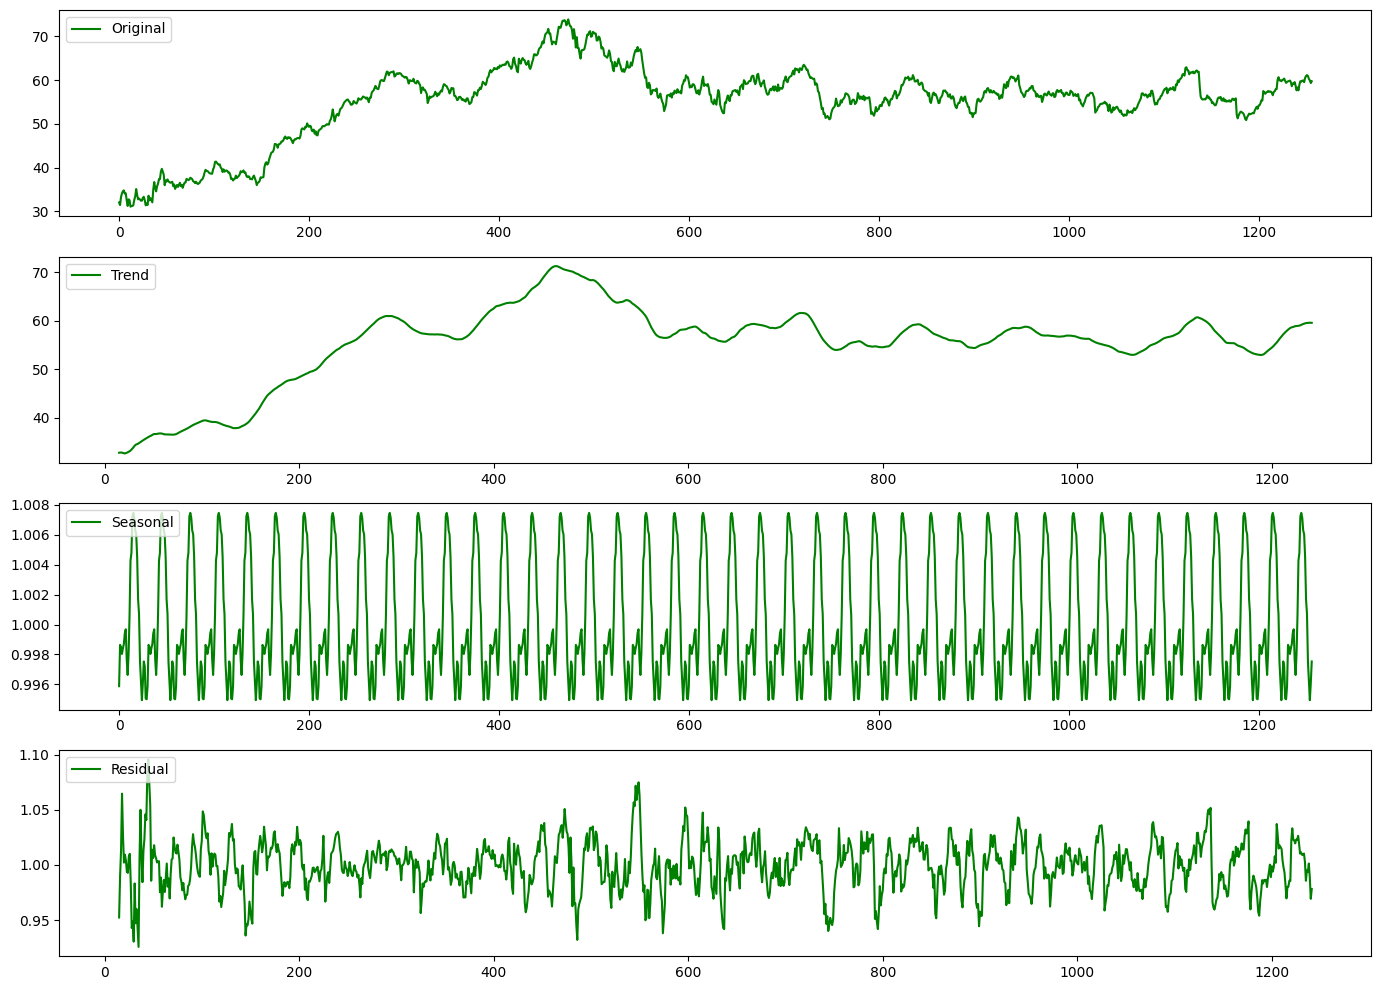

In [10]:
decomposition_multiplicative = seasonal_decompose(df['Close'], model='multiplicative', period=30)

trend_multiplicative    = decomposition_multiplicative.trend
seasonal_multiplicative = decomposition_multiplicative.seasonal
residual_multiplicative = decomposition_multiplicative.resid

# Plotting the multiplicative decomposition
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(df['Close'], label='Original', color='green')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend_multiplicative, label='Trend', color='green')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal_multiplicative, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual_multiplicative, label='Residual', color='green')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# ADF Test

In [11]:
from statsmodels.tsa.stattools import adfuller


def adf_test(series, column_name='Time Series'):
    """
    Runs the Augmented Dickey-Fuller test to check stationarity.

    Parameters:
    - series: pandas Series to test
    - column_name: str, optional name for printing

    Prints ADF statistics and conclusion.
    """
    print(f"\nADF Test for '{column_name}'")
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations Used']
    for val, label in zip(result[:4], labels):
        print(f"{label}: {val}")

    if result[1] <= 0.05:
        print("✅ Result: The series is stationary (reject null hypothesis)")
    else:
        print("❌ Result: The series is non-stationary (fail to reject null hypothesis)")

In [12]:
adf_test(df['Close'], 'Close Price')


ADF Test for 'Close Price'
ADF Statistic: -2.7900583288277767
p-value: 0.0597079577182304
# Lags Used: 1
# Observations Used: 1255
❌ Result: The series is non-stationary (fail to reject null hypothesis)


# Making data stationary

In [13]:
df['Close_Diff'] = df['Close'].diff()
df.dropna(inplace=True)

adf_test(df['Close_Diff'], 'Close Price (1st Difference)')


ADF Test for 'Close Price (1st Difference)'
ADF Statistic: -33.855965892939736
p-value: 0.0
# Lags Used: 0
# Observations Used: 1255
✅ Result: The series is stationary (reject null hypothesis)


# Plot ACF

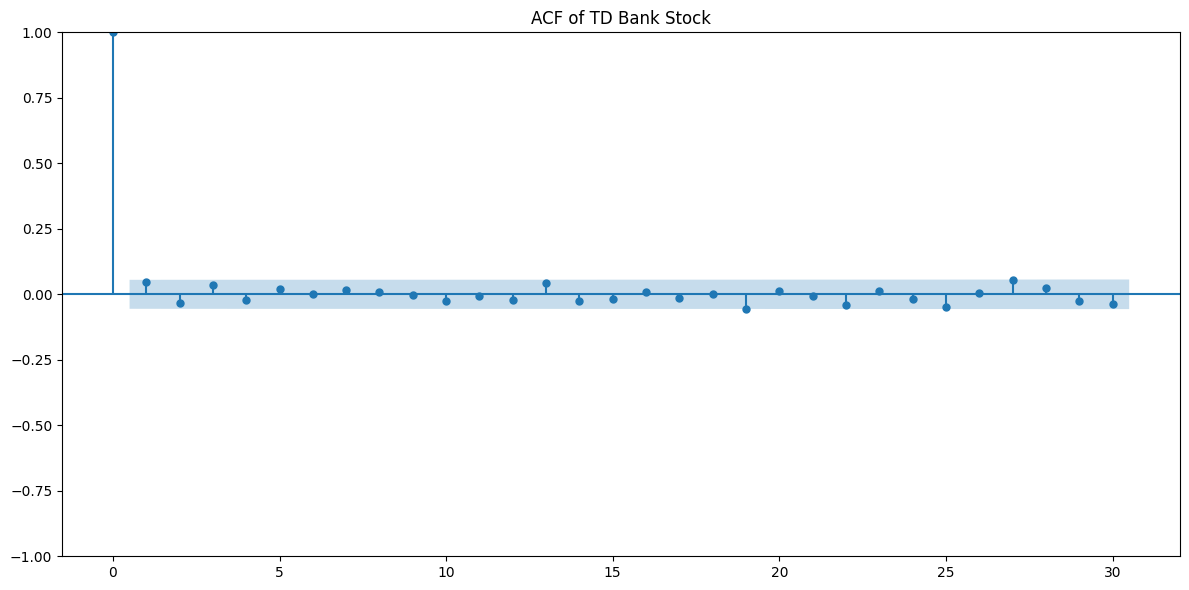

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 6))


# ACF Plot
plt.subplot(1, 1, 1)
plot_acf(df['Close'].diff().dropna(), ax=plt.gca(), lags=30)
plt.title('ACF of TD Bank Stock')

plt.tight_layout()
plt.show()

# Random Walk and White Noise

In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

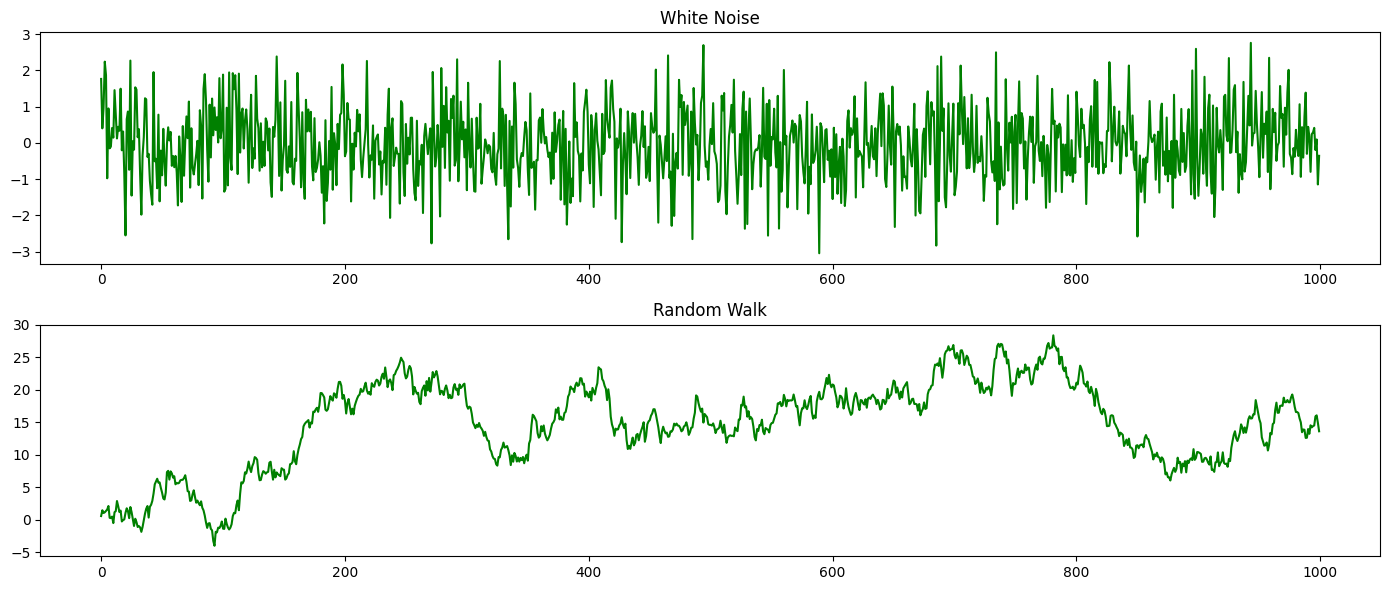


ADF Test for White Noise:

ADF Test for 'White Noise'
ADF Statistic: -32.462559337689974
p-value: 0.0
# Lags Used: 0
# Observations Used: 999
✅ Result: The series is stationary (reject null hypothesis)

ADF Test for Random Walk:

ADF Test for 'Random Walk'
ADF Statistic: -2.7978730526942797
p-value: 0.05857823023908068
# Lags Used: 0
# Observations Used: 999
❌ Result: The series is non-stationary (fail to reject null hypothesis)

Ljung-Box Test for White Noise:
      lb_stat  lb_pvalue
10  14.025574   0.171828

Ljung-Box Test for Random Walk:
        lb_stat  lb_pvalue
10  8828.660312        0.0


In [16]:
from statsmodels.tsa.stattools import adfuller, acf, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
import pandas as pd  # Import pandas

# Generating white noise and random walk for comparison
np.random.seed(0)
n = 1000

# White Noise
white_noise = np.random.normal(0, 1, n)

# Random Walk
random_shocks = np.random.normal(0, 1, n)
random_walk = np.cumsum(random_shocks)

# Plotting the series
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(white_noise, color = 'green')
plt.title(f'White Noise')

plt.subplot(2, 1, 2)
plt.plot(random_walk, color = 'green')
plt.title(f'Random Walk')

plt.tight_layout()
plt.show()

print("\nADF Test for White Noise:")
# Convert white_noise to pandas Series before calling adf_test
adf_test(pd.Series(white_noise), 'White Noise')

print("\nADF Test for Random Walk:")
# Convert random_walk to pandas Series before calling adf_test
adf_test(pd.Series(random_walk), 'Random Walk')

# Ljung-Box test
print("\nLjung-Box Test for White Noise:")
lb_test_white_noise = acorr_ljungbox(white_noise, lags=[10], return_df=True)
print(lb_test_white_noise)

print("\nLjung-Box Test for Random Walk:")
lb_test_random_walk = acorr_ljungbox(random_walk, lags=[10], return_df=True)
print(lb_test_random_walk)

**Null Hypothesis (H0):**  There is no autocorrelation between series and its lagged version.

**Alternative Hypothesis (H1):** There is autocorrelation between series and its lagged version.

If the p-value of Ljung-Box Test is less than the significance value, we reject the null hypothesis of no autocorrelation.

In [17]:
# testing on td bank stock
acorr_ljungbox(df['Close'], lags=[10], return_df=True)


,lb_stat,lb_pvalue
10,11712.916945,0.0


p-value is less than 0.05, so we can say that there is autocorrelation in data means the data is a random walk.

# Split and Train Dataset

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

monthly_price = df['Close'].resample('M').last()

# Convert the Series to a DataFrame and rename the column to 'Close'
monthly_price = monthly_price.to_frame(name='Close')

split_index = int(len(monthly_price) * 0.8)
train, test = monthly_price[:split_index], monthly_price[split_index:]
forecast_index = test.index

monthly_price.head()

,Close
Date,
2020-04-30,33.749371
2020-05-31,34.581600
2020-06-30,36.044037
2020-07-31,36.252594
2020-08-31,40.821026


In [19]:
def evaluate_model(true, pred):
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, pred)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'MSE': mse}


# ARIMA (AutoRegressive Integrated Moving Average) Model

In [20]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA Model
arima_model = ARIMA(train, order=(7, 1, 9))  # (p,d,q)
arima_fit = arima_model.fit()
arima_pred = arima_fit.predict(start=len(train), end=len(train) + len(test) - 1)
arima_pred.index = forecast_index

# Evaluation
arima_metrics = evaluate_model(test, arima_pred)
arima_metrics

C:\Users\mohit\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'RMSE': 3.283511125783654,
 'MAE': 2.8410968041308413,
 'MAPE': nan,
 'MSE': 10.78144531314504}

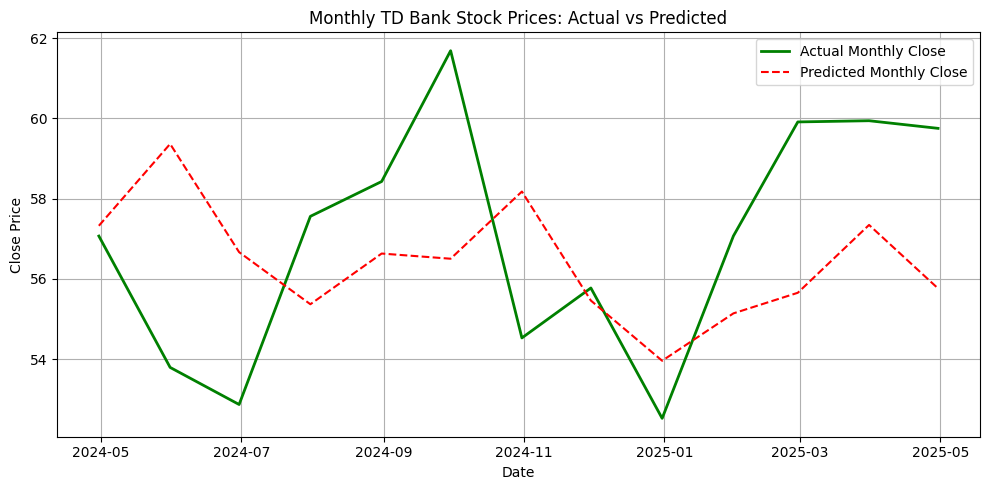

In [21]:
# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual Monthly Close', linewidth=2, color="green")
plt.plot(test.index, arima_pred, color='red', linestyle='--', label='Predicted Monthly Close')
plt.title('Monthly TD Bank Stock Prices: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Exponential Smoothing (ETS) Model

In [22]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

close_prices = monthly_price['Close']
ses_model = SimpleExpSmoothing(close_prices).fit(smoothing_level=0.2)


C:\Users\mohit\AppData\Roaming\Python\Python312\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


SES Model Metrics: {'RMSE': 3.01472629404804, 'MAE': 2.7073713574805995, 'MAPE': 4.767137220362374, 'MSE': 9.08857462802463}


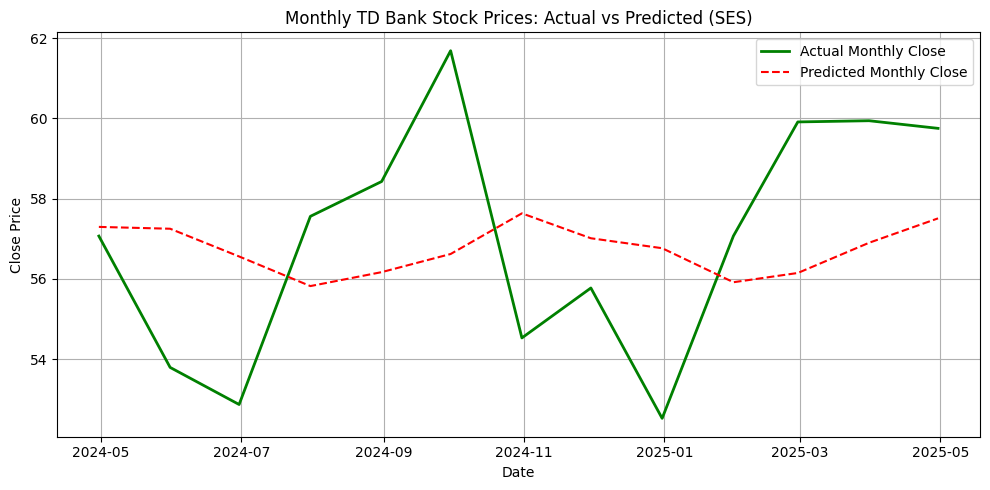

In [23]:
# Make predictions on the test set
ses_pred = ses_model.predict(start=test.index[0], end=test.index[-1])

# Evaluation
ses_metrics = evaluate_model(test['Close'], ses_pred)
print("SES Model Metrics:", ses_metrics)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Close'], label='Actual Monthly Close', linewidth=2, color="green")
plt.plot(test.index, ses_pred, color='red', linestyle='--', label='Predicted Monthly Close')
plt.title('Monthly TD Bank Stock Prices: Actual vs Predicted (SES)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LSTM Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(monthly_price.values.reshape(-1, 1))

In [25]:
# Prepare supervised data
def create_lagged_dataset(data, lag=12):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i-lag:i])
        y.append(data[i])
    return np.array(X), np.array(y)

{'RMSE': 3.527904500312318,
 'MAE': 2.8082700876089226,
 'MAPE': 5.09974680403786,
 'MSE': 12.446110163323908}  = lag: 12

{'RMSE': 3.1006811018082483,
 'MAE': 2.642903254582331,
 'MAPE': 4.718999344065168,
 'MSE': 9.614223295110813}  = lag: 6

 {'RMSE': 3.3094546482692344,
 'MAE': 2.9749471224271327,
 'MAPE': 5.286575076327253,
 'MSE': 10.95249006895084}  = lag: 3

 {'RMSE': 3.4773962673132277,
 'MAE': 3.109144650972807,
 'MAPE': 5.349352421658283,
 'MSE': 12.09228479992397}  = lag: 1

In [26]:
lag = 6
X, y = create_lagged_dataset(scaled, lag)
train_X, test_X = X[:split_index-lag], X[split_index-lag:]
train_y, test_y = y[:split_index-lag], y[split_index-lag:]

# Reshape for LSTM
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

# Build and train model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(lag, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(train_X, train_y, epochs=100, verbose=0)

# Predict and inverse scale
lstm_pred = lstm_model.predict(test_X)
lstm_pred = scaler.inverse_transform(lstm_pred)
actual = scaler.inverse_transform(test_y.reshape(-1, 1)).flatten()
lstm_metrics = evaluate_model(actual, lstm_pred.flatten())
lstm_metrics

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


{'RMSE': 3.151893985101284,
 'MAE': 2.664093897892878,
 'MAPE': 4.765018094413484,
 'MSE': 9.934435693317653}

# Prophet Model

In [27]:
from holidays import Canada

# Prepare Data for Prophet
train_prophet = train.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
test_prophet = test.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})


# Prepare Canadian public holidays (good proxy for TSX)
canada_holidays = Canada(years=range(train_prophet['ds'].min().year, test_prophet['ds'].max().year + 2))
holiday_df = pd.DataFrame([
    {'ds': date, 'holiday': 'canadian_holiday'}
    for date in canada_holidays
])

00:27:18 - cmdstanpy - INFO - Chain [1] start processing
00:27:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model with Holidays Metrics: {'RMSE': 5.801242633007082, 'MAE': 4.771776354998295, 'MAPE': 8.153184184401924, 'MSE': 33.65441608701894}


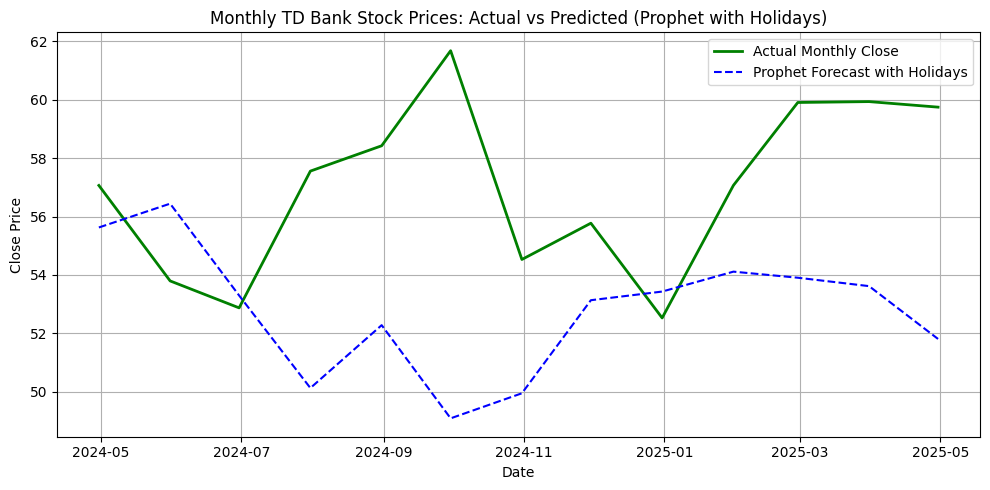

In [28]:
from prophet import Prophet

# Build and Fit Prophet Model
model = Prophet(
    holidays=holiday_df,
    daily_seasonality=False,
    yearly_seasonality=True,
    weekly_seasonality=False
)
model.fit(train_prophet)

# Make Future DataFrame & Forecast
future = model.make_future_dataframe(periods=len(test), freq='M')
forecast = model.predict(future)

# Extract only test period from forecast
forecast_filtered = forecast.set_index('ds').loc[forecast_index]['yhat']

# Evaluate and print metrics
prophet_metrics = evaluate_model(test['Close'], forecast_filtered)
print("Prophet Model with Holidays Metrics:", prophet_metrics)

# --- Step 3: Plot Actual vs Predicted (like SES style) ---
plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Close'], label='Actual Monthly Close', linewidth=2, color="green")
plt.plot(test.index, forecast_filtered, color='blue', linestyle='--', label='Prophet Forecast with Holidays')
plt.title('Monthly TD Bank Stock Prices: Actual vs Predicted (Prophet with Holidays)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Forecast Metrics Comparision

In [29]:
# Results
forecast_comparison = pd.DataFrame({
    'ARIMA': arima_metrics,
    'ETS':   ses_metrics,
    'Prophet': prophet_metrics,
    'LSTM': lstm_metrics
}).T

# Convert all columns to percentage values with 2 decimal places
for col in forecast_comparison.select_dtypes(include=['number']):
    forecast_comparison[col] = (forecast_comparison[col]).round(2)

# Display the modified dataframe.
forecast_comparison


,RMSE,MAE,MAPE,MSE
ARIMA,3.28,2.84,NaN,10.78
ETS,3.01,2.71,4.77,9.09
Prophet,5.80,4.77,8.15,33.65
LSTM,3.15,2.66,4.77,9.93
